In [2]:
import pandas as pd
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp
import numpy as np
from hyperopt import Trials, tpe, fmin
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier


In [3]:
ma = pd.read_csv("../16 Mycoplosma/ma.csv")
map = pd.read_csv("../16 Mycoplosma/map.csv")
marth = pd.read_csv("../16 Mycoplosma/marth.csv")
mcap = pd.read_csv("../16 Mycoplosma/mcap.csv")
mcon = pd.read_csv("../16 Mycoplosma/mcon.csv")
mcro = pd.read_csv("../16 Mycoplosma/mcro.csv")
mgal = pd.read_csv("../16 Mycoplosma/mgal.csv")
mhom = pd.read_csv("../16 Mycoplosma/mhom.csv")
mhyoJ = pd.read_csv("../16 Mycoplosma/mhyoJ.csv")
mhyo232 = pd.read_csv("../16 Mycoplosma/mhyo232.csv")
mhyo7448 = pd.read_csv("../16 Mycoplosma/mhyo7448.csv")
mm163K = pd.read_csv("../16 Mycoplosma/mm163K.csv")
mms = pd.read_csv("../16 Mycoplosma/mms.csv")
mpHF = pd.read_csv("../16 Mycoplosma/mpHF.csv")
mpM = pd.read_csv("../16 Mycoplosma/mpM.csv")
ms53 = pd.read_csv("../16 Mycoplosma/ms53.csv")

In [4]:
def generate_train_test_dataset(index):
    dataset_names = [ma, map, marth, mcap, mcon, mcro, mgal, mhom, mhyoJ, mhyo232, mhyo7448, mm163K, mms, mpHF, mpM, ms53]
    merged_train = dataset_names[:index]+dataset_names[index+1:]
    train_data = pd.concat(merged_train)
    test_data = dataset_names[index]
    return train_data,test_data

In [5]:
train_data , test_data = generate_train_test_dataset(0)

In [9]:
def handle_dataset(dataset):
    columns_to_drop = ['identity','name', 'Amino acid', 'protein_sequence', 'essentiality']
    Xs = dataset.drop(columns = columns_to_drop)
    y = dataset['essentiality']
    return Xs,y

In [6]:
Xs_train,y_train = handle_dataset(train_data)
Xs_test,y_test = handle_dataset(test_data)

In [7]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)

In [5]:
def mlp_bca_cv(args):
    scorer = make_scorer(balanced_accuracy_score)
    model = MLPClassifier(hidden_layer_sizes=(int(args['layer_size']),),                         max_iter=int(args['max_iter']),
                        alpha=args['alpha'], tol=1e-4, 
                        random_state=1, activation=args['activation'], 
                        learning_rate_init=args['learning_rate']
                       )
    score = -cross_val_score(model, X_resampled, y_resampled, cv=5,scoring=scorer ).mean()
    return score

In [25]:
def mlp_bca_cv_2(args):
    scorer = make_scorer(balanced_accuracy_score)
    model = MLPClassifier(hidden_layer_sizes=(int(args['layer_size']),),                         max_iter=int(args['max_iter']),
                        alpha=args['alpha'], tol=1e-4, 
                        random_state=1, activation=args['activation'], 
                        learning_rate_init=args['learning_rate']
                       )
    score = -cross_val_score(model, Xs_train, y_train, cv=5,scoring=scorer ).mean()
    return score

In [6]:
space = {'layer_size':hp.quniform('layer_size', 25, 300, 1),
         'alpha':hp.lognormal('alpha', mu=np.log(1e-4), sigma=1),
         'activation':hp.choice('activation', ['logistic', 'tanh', 'relu']),
         'max_iter': hp.quniform('max_iter', 100, 3000, 100),
         'learning_rate':hp.loguniform('learning_rate', low=np.log(1e-4), high=np.log(1.)),
        }

In [7]:
import warnings
warnings.filterwarnings("ignore")
trials = Trials()

In [36]:

best=fmin(fn=mlp_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=100, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(1) # fixing random state for the reproducibility
         )


100%|██████████| 100/100 [05:05<00:00,  3.05s/trial, best loss: -0.7913160355306218]


In [37]:
best

{'activation': 1,
 'alpha': 0.031462537249946146,
 'layer_size': 73.0,
 'learning_rate': 0.0005684316445598827,
 'max_iter': 2700.0}

In [20]:
trials = Trials()
best2=fmin(fn=mlp_bca_cv_2, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=100, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
         )

100%|██████████| 100/100 [02:31<00:00,  1.51s/trial, best loss: -0.5040690156780345]


In [39]:
best_model = MLPClassifier(hidden_layer_sizes=73,                            max_iter=2700,alpha=0.031462537249946146, tol=1e-4,  random_state=1, activation='tanh', learning_rate_init=0.0005684316445598827)
best_model.fit(X_resampled,y_resampled)
tpe_test_score=balanced_accuracy_score(y_test, best_model.predict(Xs_test))
print(tpe_test_score)

0.884180790960452


In [40]:
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#feature selection
#RFE
score = []
scorer = make_scorer(balanced_accuracy_score)
for i in range(26,5,-1):
	X_mutual = SelectKBest(score_func=mutual_info_classif, k=i).fit_transform(X_resampled, y_resampled)
	once = cross_val_score(best_model, X_mutual, y_resampled, cv=10,scoring=scorer)
	score.append(once.mean())


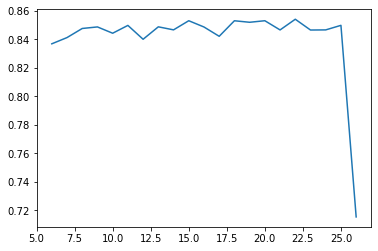

In [41]:
plt.plot(range(26,5,-1), score)
plt.show()    

In [47]:
def feature_selection(Xs,y):
    Xs_result = SelectKBest(mutual_info_classif, k=25).fit_transform(Xs,y)
    return Xs_result

In [55]:
models= []
score = 0
scores = []
i = 0
for i in range(1,15):
    """
    if i == 3 :
        scores.append(0.5127968346578312)
        continue
    if i ==12:
        scores.append(0.5123582987129056)
        continue"""
    train_data, test_data = generate_train_test_dataset(i)
    Xs_train,y_train = handle_dataset(train_data)
    Xs_test,y_test = handle_dataset(test_data)
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
    X_resampled = feature_selection(X_resampled,y_resampled)
    trials = Trials()
    best=fmin(fn=mlp_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
    )
    activations = ['logistic', 'tanh', 'relu']
    model = MLPClassifier(hidden_layer_sizes=int(best['layer_size']),                            max_iter=int(best['max_iter']),alpha=best['alpha'], tol=1e-4,  random_state=1, activation=activations[best['activation']], learning_rate_init=best['learning_rate'])
    models.append(model)
    model.fit(X_resampled,y_resampled)
    Xs_test_fs = feature_selection(Xs_test,y_test)
    tpe_test_score=balanced_accuracy_score(y_test, model.predict(Xs_test_fs))
    scores.append(tpe_test_score)
    print(tpe_test_score)
    if score < tpe_test_score:
        score = tpe_test_score
        best_model = model

100%|██████████| 50/50 [04:12<00:00,  5.05s/trial, best loss: -0.8531228551818806]
0.5
100%|██████████| 50/50 [03:24<00:00,  4.08s/trial, best loss: -0.8574414715719063]
0.5
100%|██████████| 50/50 [04:01<00:00,  4.84s/trial, best loss: -0.8484572230014026]
0.5012820512820513
100%|██████████| 50/50 [05:20<00:00,  6.42s/trial, best loss: -0.8670784717455959]
0.5
100%|██████████| 50/50 [05:08<00:00,  6.17s/trial, best loss: -0.8711050102951269]
0.5
100%|██████████| 50/50 [04:33<00:00,  5.48s/trial, best loss: -0.858046398046398] 
0.5
100%|██████████| 50/50 [04:22<00:00,  5.24s/trial, best loss: -0.8626401281171356]
0.5
100%|██████████| 50/50 [03:43<00:00,  4.47s/trial, best loss: -0.8465871902758298]
0.5
100%|██████████| 50/50 [04:58<00:00,  5.97s/trial, best loss: -0.8515789473684212]
0.5
100%|██████████| 50/50 [02:53<00:00,  3.48s/trial, best loss: -0.85]              
0.5


In [12]:

for i in range(3,15):
    if i == 3 :
        score2.append(0.5127968346578312)
        continue
    if i ==12:
        score2.append(0.5123582987129056)
        continue
    train_data, test_data = generate_train_test_dataset(i)
    Xs_train,y_train = handle_dataset(train_data)
    Xs_test,y_test = handle_dataset(test_data)
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
    trials = Trials()
    best=fmin(fn=mlp_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
    )
    activations = ['logistic', 'tanh', 'relu']
    model = MLPClassifier(hidden_layer_sizes=int(best['layer_size']),                            max_iter=int(best['max_iter']),alpha=best['alpha'], tol=1e-4,  random_state=1, activation=activations[best['activation']], learning_rate_init=best['learning_rate'])
    model2.append(model)
    model.fit(X_resampled,y_resampled)
    tpe_test_score=balanced_accuracy_score(y_test, model.predict(Xs_test))
    score2.append(tpe_test_score)
    print(tpe_test_score)
    if score < tpe_test_score:
        score = tpe_test_score
        best_model = model

100%|██████████| 50/50 [02:19<00:00,  2.80s/trial, best loss: -0.8056623198352779]
0.7867306703240184
100%|██████████| 50/50 [06:01<00:00,  7.24s/trial, best loss: -0.8312947921643573]
0.8221153846153846
100%|██████████| 50/50 [05:13<00:00,  6.27s/trial, best loss: -0.8171458625525947]
0.8217948717948718
100%|██████████| 50/50 [03:54<00:00,  4.69s/trial, best loss: -0.8273850377487989]
0.8689636462289745
100%|██████████| 50/50 [07:26<00:00,  8.92s/trial, best loss: -0.8359071150766415]
0.7348484848484849
100%|██████████| 50/50 [05:31<00:00,  6.64s/trial, best loss: -0.794175824175824] 
0.6531522698303756
100%|██████████| 50/50 [05:36<00:00,  6.74s/trial, best loss: -0.8050789293067948]
0.8535984848484848
100%|██████████| 50/50 [04:32<00:00,  5.44s/trial, best loss: -0.8034244974287048]
0.8570381231671554
100%|██████████| 50/50 [08:52<00:00, 10.64s/trial, best loss: -0.8010526315789473]
0.8256410256410256
100%|██████████| 50/50 [03:39<00:00,  4.39s/trial, best loss: -0.8089285714285716]

In [13]:
print(score2)

[0.6280353200883002, 0.7067466887417219, 0.5127968346578312, 0.7867306703240184, 0.8221153846153846, 0.8217948717948718, 0.8689636462289745, 0.7348484848484849, 0.6531522698303756, 0.8535984848484848, 0.8570381231671554, 0.5123582987129056, 0.8256410256410256, 0.6351590851548654]


In [14]:
train_data, test_data = generate_train_test_dataset(7)
Xs_train,y_train = handle_dataset(train_data)
Xs_test,y_test = handle_dataset(test_data)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
trials = Trials()
best=fmin(fn=mlp_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
          )


100%|██████████| 50/50 [06:43<00:00,  8.07s/trial, best loss: -0.8273850377487989]


KeyError: 'n_estimators'

In [15]:
best_model = MLPClassifier(hidden_layer_sizes=int(best['layer_size']),                            max_iter=int(best['max_iter']),alpha=best['alpha'], tol=1e-4,  random_state=1, activation=activations[best['activation']], learning_rate_init=best['learning_rate'])
best_model.fit(X_resampled,y_resampled)

MLPClassifier(activation='tanh', alpha=7.782908668883826e-06,
              hidden_layer_sizes=101, learning_rate_init=0.0006366437064143067,
              max_iter=1200, random_state=1)

In [16]:
from joblib import dump

dump(best_model, '../../model/MLP_model.joblib')

['../../model/MLP_model.joblib']

In [17]:
test_score = balanced_accuracy_score(y_test,best_model.predict(Xs_test))

In [18]:
print(test_score)

0.8689636462289745
